# **Signal 1D processing example using scipy, pandas and matplotlib**

We have one day 1Hz GNSS data at a point. We'll analyse the altitudes. The data are given in a csv file (https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/one_day.csv). the six columns in the file are: point_id, date/time, east, north, ellevation, code. The few first lines are:

```
2020-10-09 00:00:00,650769.386,237227.828,138.455,4
2020-10-09 00:00:01,650769.382,237227.823,138.452,4
2020-10-09 00:00:02,650769.382,237227.825,138.456,4
2020-10-09 00:00:03,650769.383,237227.824,138.455,4
2020-10-09 00:00:04,650769.384,237227.823,138.457,4
2020-10-09 00:00:05,650769.385,237227.824,138.464,4
```




Let's read in the input file using pandas. Pandas is a popular Python module for data analysis and manipulation.

In [ ]:
import pandas as pd

names=['dt', 'east', 'north', 'elev', 'code'] # column names in csv input file
data = pd.read_csv('https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/data_processing/lessons/code/one_day.csv', sep=',', names=names, parse_dates=['dt'])
data.head

<bound method NDFrame.head of                        dt        east       north     elev  code
0     2020-10-09 00:00:00  650769.386  237227.828  138.455     4
1     2020-10-09 00:00:01  650769.382  237227.823  138.452     4
2     2020-10-09 00:00:02  650769.382  237227.825  138.456     4
3     2020-10-09 00:00:03  650769.383  237227.824  138.455     4
4     2020-10-09 00:00:04  650769.384  237227.823  138.457     4
...                   ...         ...         ...      ...   ...
86357 2020-10-09 23:59:55  650769.387  237227.831  138.451     4
86358 2020-10-09 23:59:56  650769.386  237227.831  138.447     4
86359 2020-10-09 23:59:57  650769.386  237227.830  138.444     4
86360 2020-10-09 23:59:58  650769.388  237227.829  138.445     4
86361 2020-10-09 23:59:59  650769.387  237227.828  138.445     4

[86362 rows x 5 columns]>

Let's examine some statistical values of the elevations (e.g. mean, min, max, standard deviation)

In [ ]:
data['elev'].describe()

count    86362.000000
mean       138.448103
std          0.007281
min        138.419000
25%        138.443000
50%        138.448000
75%        138.453000
max        138.477000
Name: elev, dtype: float64

The mean error (standard deviation) looks very promissing (7 mm), but the range of the values is ~6 cm. On the other hand we have only 86362 epoch, instead of 86400 (24 * 60 * 60).

The ranges of the quartiles are (min - 25%, 25 - 50%, 50 - 75%, 75% - max):

```
34 mm, 5 mm, 5 mm, 25 mm
```

Let's examine the empirical density function of the elevations and the skewness of the data. If skewness is zero, then the densitiy function is symmetrical.

Skewness: -0.009, Mean - Median: 0.000


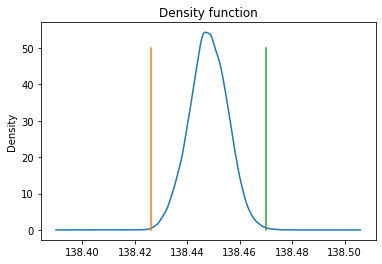

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = data['elev'].plot.kde()
ax.set_title('Density function')
avg = data['elev'].mean()
median = data['elev'].median()
std = data['elev'].std()
ax.plot([avg - 3 * std, avg - 3 * std], [0, 50], [avg + 3 *std, avg + 3 * std], [0, 50])
print('Skewness: {:.3f}, Mean - Median: {:.3f}'.format(data['elev'].skew(), avg - median))

Leat's have a look to the data.

Text(0.5, 1.0, 'Elevations')

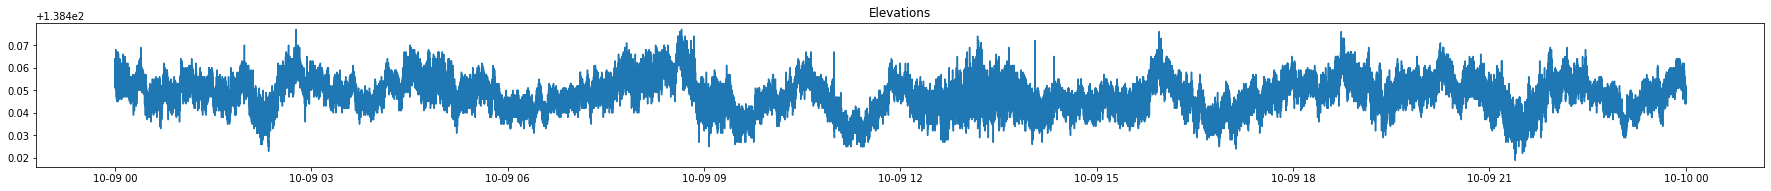

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(data['dt'], data['elev'])
ax.set_title('Elevations')

We can realize the data are noisy and there may be some periodicy in it. First let's smooth data with the median of moving 60 seconds long window, to remove random noise.



In [ ]:
win = 40    # window width for smoothing
data['smooth_elev'] = pd.DataFrame(data[['elev']].rolling(window=60, center=True).median())
# next command does the same as rolling but much slower
#data['test'] = [(data['elev'][i-win//2:i+win//2]).median() if i >=30 and i < data.shape[0]-win/2 else avg for i in data.index]

Before we go further analysing data, find and fill the gaps in the data set.

In [ ]:
from datetime import timedelta
deltas = data['dt'].diff()[1:]      # calculate difference between adjecent time stamps 
dd = deltas[deltas > timedelta(seconds=1)]  # select differences larger 1 second

We have two gaps (13 seconds and 27 seconds). Using the indices (24781 and 35908) we can find the time of the gap

In [ ]:
for i in dd.index:
  print(data.iloc[[i-1,i]])


                       dt        east  ...            diff  seconds
24780 2020-10-09 06:53:00  650769.387  ... 0 days 06:53:00  24780.0
24781 2020-10-09 06:53:13  650769.389  ... 0 days 06:53:13  24793.0

[2 rows x 8 columns]
                       dt        east  ...            diff  seconds
35907 2020-10-09 09:58:39  650769.380  ... 0 days 09:58:39  35919.0
35908 2020-10-09 09:59:06  650769.383  ... 0 days 09:59:06  35946.0

[2 rows x 8 columns]


For further processing we have to fill these gaps. These two gaps are sorter than a minute, so we may use linear interpolation.

In [ ]:
data['diff'] = data['dt'] - data['dt'].min()      # calculate time difference from the first epoch
data['seconds'] = data['diff'].dt.total_seconds() # time difference in seconds from the first epoch
x_orig = data['seconds'].to_numpy()               # convert pandas data series to numpy array
y_orig = data['smooth_elev'].to_numpy()
yy_orig = data['elev'].to_numpy()
import numpy as np
for i in range(0, win//2):                       # generate smoothed data for the missing first minute
  y_orig[i] = np.median(yy_orig[0:i+1])            # medians for shorter interval
  y_orig[-i] = np.median(yy_orig[-i-2:-1])
x = np.arange(0, x_orig[-1])                       # generate array for each seconds
y = np.interp(x, x_orig, y_orig)                   # linear interpolation from (x_orig, y_orig) data for each seconds

Let's display the first 5 minutes of original and smoothed data. Note the first minute missing from the smoothed data.

Text(0.5, 1.0, 'Original and smoothed data, first 5 minutes')

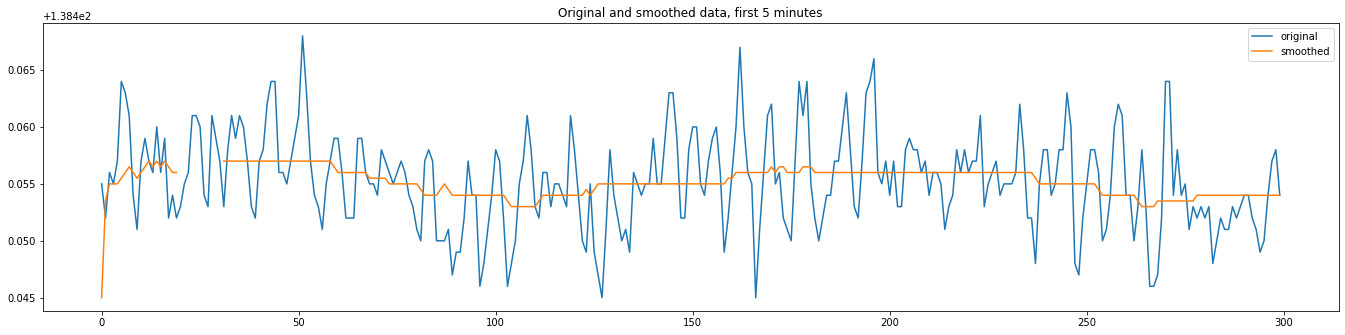

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
ax.plot(x_orig[0:300], data['elev'].to_numpy()[0:300], label='original')
ax.plot(x[0:300], y[0:300], label='smoothed')
ax.legend()
ax.set_title('Original and smoothed data, first 5 minutes')

Now we start the spectral analysis of elevation time serie. First we remove the linear trend if there is any.

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
xx = x_orig.reshape(-1, 1)      # use original points
model.fit(xx, y_orig)           # calculate linear regression
intercept = model.intercept_    # intercept on y axis
coef = model.coef_              # slope
from math import atan, pi
print('{:.3f} {:.6f}'.format(intercept, atan(coef[0]) * 360 / pi))
y_no_trend = y - intercept - x * coef[0]   # remove trend from serie

ValueError: ignored

Let's try to find the significant spectrums in data using FFT. We'll convert data from time domain to frquency domain.

In [ ]:
from scipy.fft import rfft, rfftfreq, irfft
sample_rate = 1                     # 1 Hz input data
nfreq = 10                          # number of significanf frequences to save
n = x.size                          # number of data point
yf = rfft(y_no_trend)               # calculate FFT
xf = rfftfreq(n, 1 / sample_rate)   # calculate vector of frquences
ayf = np.abs(yf)
f = np.sort(ayf)[::-1][:nfreq]      # get the most significant frequencies
iyf = np.zeros(yf.shape[0])         # for inverse FFT
freqs = []
print("Significant frequences")
print("     FFT      index   frequency     wave l   ampl")
print("                         [Hz]       [hour]   [m]")
for v in f:
  i = np.where(ayf == v)[0][0]  # get index of frequency
  iyf[i] = ayf[i]
  print("{:10.1f} {:8d} {:12.8f} {:8.3f} {:8.4f}".format(v, i, xf[i], 1/ xf[i] / 3600, v / n))
ifft = irfft(iyf)   # inverse FFT for significant frequences

Let's display frequency space.

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 3, 1])
ax.plot(xf[:200], ayf[:200] / 120)
ax.set_title('Frequency domain (scaled down to (0-1))')

and the inverse FFT for the first 10 most significant frequences.

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 4., 0.5])    # dimensions of the chart window
ax.plot(x, y, label='original')
yyy = ifft + intercept + x[:-1] * coef[0]   # linear trend added
ax.plot(x[:-1], yyy, label='FFT')
ax.set_title('original data and fourier serie of the 10 most significant frequency')
ax.legend()

Do the two function match? It is far from perfect match. How close are these functions? Let's calculate mean squera error (RMSE).

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE = mean_squared_error(y[:-1], yyy)
RMSE = sqrt(MSE)
print('RMSE: {:.4f}'.format(RMSE))

**Tasks for practice**:

*   Repeat the process without smoothing, using the original observation
*   Generate sample data with known frequences and random noise, process these data and check the most significant frequences 

